# vnf

In [1]:
from numbers import Real

import numpy as np
import numpy.typing as npt


def _energy_decay(alpha: float, number_of_impulses: int) -> float:
    """
    Given the alpha value and the number of impulses, what is the target decay?
    L_db = 20 log_10 (exp(-alpha M))
    """
    return 20.0 * np.log10(np.exp(-alpha * number_of_impulses))


def _inverse_energy_decay(target_decay: float, number_of_impulses: int) -> float:
    """
    Given the energy decay and the number of impulses, what is the alpha?
    """
    return (-1 / number_of_impulses) * np.log(np.power(10, target_decay / 20))


def _make_decaying_sample(size: int, alpha: float) -> npt.NDArray[np.float32]:
    rng = np.random.default_rng()
    samples = np.zeros((size,), dtype=np.float32)
    for i in range(size):
        samples[i] = np.exp(-alpha * i) * rng.choice([1, -1]) # * rng.uniform(0.5, 2)
    return samples


def velvet_noise(sample_rate: Real,
                 filter_length_ms: Real,
                 number_of_impulses: int,
                 target_decay: float) -> npt.NDArray[np.float32]:
    """
    Create a velvet noise discrete-time signal.
    :param sample_rate: the sample rate of the returned signal
    :param filter_length_ms: the total milliseconds of the returned signal
    :param number_of_impulses: the number of non-zero samples in the returned noise
    :param target_decay: the amount of decay applied on non-zero samples
    :return: a velvet noise. The returned data bit-rate is 32-bit
    """

    # Parameter value and type check
    if sample_rate <= 0:
        raise ValueError(f'The sample rate should be a positive real number. Got {sample_rate}')
    if filter_length_ms <= 0:
        raise ValueError(f'The filter length should be a positive real number. Got {filter_length_ms}')
    if number_of_impulses <= 0:
        raise ValueError(f'The total number of impulses cannot be non-positive. Got {number_of_impulses}')
    if target_decay > 0:
        raise ValueError(f'The target decay is expected to be negative. Got {target_decay}')

    rng = np.random.default_rng()
    filter_size = np.int32(sample_rate * filter_length_ms / 1000)

    velvet_noise_return = np.zeros((filter_size,), dtype=np.float32)

    alpha = _inverse_energy_decay(target_decay, number_of_impulses)

    indices = np.sort(rng.choice(filter_size, size=(number_of_impulses,), replace=False, shuffle=False))
    decaying_sample = _make_decaying_sample(number_of_impulses, alpha)
    velvet_noise_return[indices] = decaying_sample

    return velvet_noise_return

# plot

In [2]:
import numpy as np
import matplotlib.pyplot as plt


def plot_freqz(w, h):
    """
    A helper function to acquire a plot directly from `scipy.signal.freqz` function.
    """
    fig, ax1 = plt.subplots()

    ax1.set_title('Digital filter frequency response')
    ax1.plot(w, 20 * np.log10(abs(h)), 'b')
    ax1.set_ylabel('Amplitude [dB]', color='b')
    ax1.set_xlabel('Frequency [rad/sample]')

    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    ax2.plot(w, angles, 'g')
    ax2.set_ylabel('Angle (radians)', color='g')
    ax2.grid()
    ax2.axis('tight')


def no_output(*args):
    pass

In [5]:
import matplotlib.pyplot as plt
from scipy import signal

The velvet noise proposed by the study has the following parameters:
* $f_s$: the sample rate
* $\rho$: the density of non-zero impulses
* $\alpha$: the decay rate

And when it comes to production, we use these parameters:
* $L_s$: the length of the filter in milliseconds
* $M$: the number of impulses (non-zero samples)
* $L_\text{dB}$: the target decay

We also need the sample rate $f_s$. 

In [3]:
sr = 44100.0

We create our first velvet noise filter with the following parameters:
- $L_s$, the length of the filter in milliseconds, to be $10$
- $M$, the number of impulses, to be $8$
- $L_\text{dB}$, the target decay, to be $-5\text{dB}$

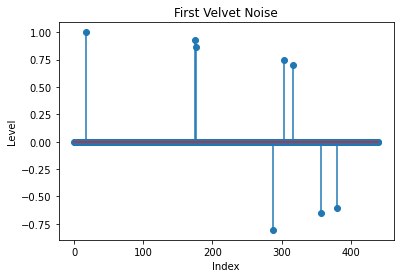

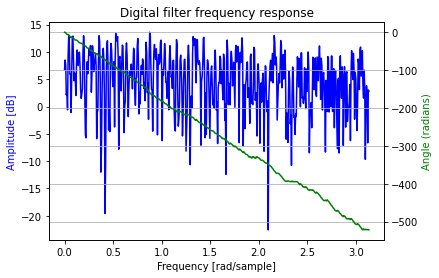

In [6]:
vn1 = velvet_noise(sr, 10, 8, -5)
plt.stem(vn1)
plt.title('First Velvet Noise')
plt.xlabel('Index')
plt.ylabel('Level')
plt.show()
plot_freqz(*signal.freqz(vn1))

In [ ]:
def high_shelf_filter_iir(f0, gain=0., Q=1., fs=192000):
    """
    根据PEQ参数设计二阶IIR数字high shelf滤波器,默认采样率192k
    :param f0: 中心频率
    :param gain: 峰值增益
    :param Q: 峰值带宽
    :param fs: 系统采样率
    :return: 双二阶滤波器系数
    """
    A = np.sqrt(10 ** (gain / 20))
    w0 = 2 * np.pi * f0 / fs
    alpha = np.sin(w0) / (2 * Q)

    b0 = A * ((A + 1) + (A - 1) * np.cos(w0) + 2 * np.sqrt(A) * alpha)
    b1 = -2 * A * ((A - 1) + (A + 1) * np.cos(w0))
    b2 = A * ((A + 1) + (A - 1) * np.cos(w0) - 2 * np.sqrt(A) * alpha)
    a0 = (A + 1) - (A - 1) * np.cos(w0) + 2 * np.sqrt(A) * alpha
    a1 = 2 * ((A - 1) - (A + 1) * np.cos(w0))
    a2 = (A + 1) - (A - 1) * np.cos(w0) - 2 * np.sqrt(A) * alpha

    b = np.array([b0, b1, b2])
    a = np.array([a0, a1, a2])

    h = np.hstack((b / a[0], a / a[0]))

    return h



In [ ]:
def shelf(Wn, dBgain, S=1, btype='low', ftype='half', analog=False,
          output='ba'):
    """
    Design an analog or digital biquad shelving filter with variable slope.
    Parameters
    ----------
    Wn : float
        Turnover frequency of the filter, defined by the `ftype` parameter.
        For digital filters, `Wn` is normalized from 0 to 1, where 1 is the
        Nyquist frequency, pi radians/sample.  (`Wn` is thus in
        half-cycles / sample.)
        For analog filters, `Wn` is an angular frequency (e.g. rad/s).
    dBgain : float
        The gain at the center frequency, in dB.  Positive for boost,
        negative for cut.
    Q : float
        Quality factor of the filter.  Examples:
        * Q fdsafda
    ftype : {'half', 'outer', 'inner'}, optional
    fpoint?
    fdef?
        Definition of the filter's turnover frequency
        ``half``
            Wn is defined as the point on the curve at which the
            gain in dB is half of the shelf gain, or midway between the
            filter's pole and zero.  This method is used in
            "Cookbook formulae for audio EQ biquad filter coefficients"
        ``outer``
            Wn is defined as the point 3 dB up or down from the shelf's
            plateau.
            This is symmetrical in dB, so that a boost and cut with identical
            parameters sum to unity gain.
            This is defined using the location of the outer pole or zero of
            the filter (the lower of the two for a low shelf, higher of the
            two for a high shelf), so will not be exactly 3 dB at lower shelf
            gains.  This method is used in ____ hardware audio equalizers.
        ``inner``
            Wn is defined as the point 3 dB up or down from unity gain.
            This is symmetrical in dB, so that a boost and cut with identical
            parameters sum to unity gain.
    btype : {'low', 'high'}, optional
        Band type of the filter, low shelf or high shelf.
    ftype is the meaning of f, either midpoint of slope, fstop or fturnover
    turnover frequency at large boost/cuts, this is 3 dB away from unity gain
    stop frequency at large boost/cuts, this is 3 dB away from plateau
    tonmeister defines outer as fstop and inner as fturnover
        as does http://www.soundonsound.com/sos/dec05/articles/qa1205_3.htm
    Understanding Audio defines turnover as outer
        as does ems.music.utexas.edu/dwnld/mus329j10/Filter%20Basics.ppt
            also calls it knee
    R is transition ratio fstop/fturnover.  at R=1, fstop = fturnover
    If the transition ratio is less than 1, then the filter is a low shelving
    filter. If the transition ratio is greater than 1, then the filter is a
    high shelving filter.
    highShelf:
        H(s) = A * (A*s**2 + (sqrt(A)/Q)*s + 1)/(  s**2 + (sqrt(A)/Q)*s + A)
    lowShelf:
        H(s) = A * (  s**2 + (sqrt(A)/Q)*s + A)/(A*s**2 + (sqrt(A)/Q)*s + 1)
    2*sqrt(A)*alpha  =  sin(w0) * sqrt( (A**2 + 1)*(1/S - 1) + 2*A )
        is a handy intermediate variable for shelving EQ filters.
        The relationship between shelf slope and Q is
             1/Q = sqrt((A + 1/A)*(1/S - 1) + 2)
    f0 shelf midpoint frequency
    _or_ S, a "shelf slope" parameter (for shelving EQ only).  When S = 1,
        the shelf slope is as steep as it can be and remain monotonically
        increasing or decreasing gain with frequency.  The shelf slope, in
        dB/octave, remains proportional to S for all other values for a
        fixed f0/Fs and dBgain.
    """
    Q = None  # TODO: Maybe this should be a function parameter?

    if ftype in ('mid', 'half'):
        A = 10.0**(dBgain/40.0)  # for peaking and shelving EQ filters only

        if Q is None:
            Q = 1/sqrt((A + 1/A)*(1/S - 1) + 2)

        Az = A
        Ap = A

    elif ftype in ('outer'):
        A = 10.0**(dBgain/20.0)

        if Q is None:
            Q = 1/sqrt((A + 1/A)*(1/S - 1) + 2)

        if dBgain > 0:  # boost
            Az = A
            Ap = 1
        else:  # cut
            Az = 1
            Ap = A

    elif ftype in ('inner'):
        A = 10.0**(dBgain/20.0)

        if Q is None:
            Q = 1/sqrt((A + 1/A)*(1/S - 1) + 2)

        if dBgain > 0:  # boost
            Az = 1
            Ap = A
        else:  # cut
            Az = A
            Ap = 1
    else:
        raise ValueError('"%s" is not a known shelf type' % ftype)

    if btype == 'low':
        # H(s) = A * (  s**2 + (sqrt(A)/Q)*s + A)/(A*s**2 + (sqrt(A)/Q)*s + 1)
        b = Ap * np.array([1,  sqrt(Az)/Q, Az])
        a = np.array([Ap, sqrt(Ap)/Q, 1])
    elif btype == 'high':
        # H(s) = A * (A*s**2 + (sqrt(A)/Q)*s + 1)/(  s**2 + (sqrt(A)/Q)*s + A)
        b = Ap * np.array([Az, sqrt(Az)/Q, 1])
        a = np.array([1,  sqrt(Ap)/Q, Ap])
    else:
        raise ValueError('"%s" is not a known shelf type' % btype)

    return _transform(b, a, Wn, analog, output)

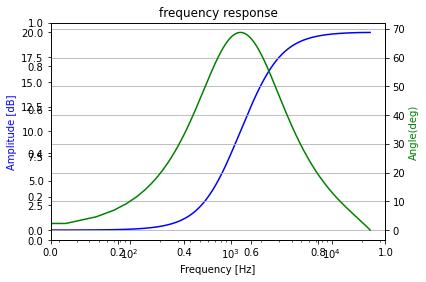

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal


class Class_IIR_highShelving1(object):
    def __init__(self, fc=2500, gain=2.0, slope=1.0, sampling_rate=48000):
        # design iir high Shelving filter
        # initalize
        self.fc= fc # midpoint frequecny by unit is [Hz]
        self.sr= sampling_rate # sampling frequecny by unit is [Hz]
        self.gain= gain # amplification factor (magnification).   This must be > 0.0
        self.gain= np.sqrt(self.gain)
        self.slope= slope # shelf slope (S=1 for steepest slope)
        self.b, self.a= self.set_highshelving()
        #print ('self.b,self.a', self.b, self.a)

    def filtering(self, xin):
    	# process filtering, using scipy
    	# input xin
    	# output filtered xin
        return signal.lfilter(self.b, self.a, xin)
        
    def f_show(self, worN=1024):
        # draw frequency response, using scipy
        wlist, fres = signal.freqz(self.b, self.a, worN=worN)
        
        fig = plt.figure()
        ax1 = fig.add_subplot(111)
        flist = wlist / ((2.0 * np.pi) / self.sr)
        plt.title('frequency response')
        ax1 = fig.add_subplot(111)
        
        plt.semilogx(flist, 20 * np.log10(abs(fres)), 'b')  # plt.plot(flist, 20 * np.log10(abs(fres)), 'b')
        
        plt.ylabel('Amplitude [dB]', color='b')
        plt.xlabel('Frequency [Hz]')
        
        ax2 = ax1.twinx()
        angles = np.unwrap(np.angle(fres))
        angles = angles / ((2.0 * np.pi) / 360.0)
        plt.semilogx(flist, angles, 'g')  # plt.plot(flist, angles, 'g')
        plt.ylabel('Angle(deg)', color='g')
        plt.grid()
        plt.axis('tight')
        plt.show()

    def set_highshelving(self,):
        
        omega= (self.fc / self.sr) * np.pi * 2.0
        sn= np.sin(omega)
        cs= np.cos(omega)
        alpha = sn / 2.0 * np.sqrt((self.gain + 1.0/self.gain) * (1.0/self.slope - 1.0) + 2.0)
        
        b=np.zeros(3) # umerator(bunsi)
        a=np.zeros(3) # denominator(bunbo)
        
        a[0]= ((self.gain + 1.0 ) - (self.gain - 1.0) * cs + 2.0 * np.sqrt(self.gain) * alpha)
        a[1]= 2.0 * (( self.gain - 1.0) - ( self.gain + 1.0) * cs)
        a[2]= ((self.gain + 1.0) - (self.gain - 1.0 ) * cs - 2.0 * np.sqrt( self.gain) * alpha )
        
        b[0]= self.gain * ((self.gain +1.0 ) + (self.gain - 1.0) * cs + 2.0 * np.sqrt(self.gain) * alpha )
        b[1]= -2.0 * self.gain * ((self.gain - 1.0) + (self.gain + 1.0 ) * cs)
        b[2]= self.gain * ((self.gain + 1.0) + (self.gain - 1.0) * cs - 2.0 * np.sqrt(self.gain) * alpha)
        
        b /= a[0]
        a /= a[0]
        
        return b, a


if __name__ == '__main__':
    
    # high shelf filter sample 
    iir_LS1=Class_IIR_highShelving1( fc=1250, gain=10.0, slope=0.75, sampling_rate=48000)
    # draw frequency response
    iir_LS1.f_show()

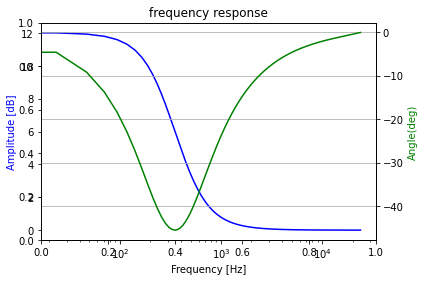

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal


class Class_IIR_LowShelving1(object):
    def __init__(self, fc=250, gain=2.0, slope=1.0, sampling_rate=48000):
        # design iir Low Shelving filter
        # initalize
        self.fc= fc # midpoint frequecny by unit is [Hz]
        self.sr= sampling_rate # sampling frequecny by unit is [Hz]
        self.gain= gain # amplification factor (magnification).   This must be > 0.0
        self.gain= np.sqrt(self.gain)
        self.slope= slope # shelf slope (S=1 for steepest slope)
        self.b, self.a= self.set_lowshelving()
        #print ('self.b,self.a', self.b, self.a)

    def filtering(self, xin):
    	# process filtering, using scipy
    	# input xin
    	# output filtered xin
        return signal.lfilter(self.b, self.a, xin)
        
    def f_show(self, worN=1024):
        # draw frequency response, using scipy
        wlist, fres = signal.freqz(self.b, self.a, worN=worN)
        
        fig = plt.figure()
        ax1 = fig.add_subplot(111)
        flist = wlist / ((2.0 * np.pi) / self.sr)
        plt.title('frequency response')
        ax1 = fig.add_subplot(111)
        
        plt.semilogx(flist, 20 * np.log10(abs(fres)), 'b')  # plt.plot(flist, 20 * np.log10(abs(fres)), 'b')
        
        plt.ylabel('Amplitude [dB]', color='b')
        plt.xlabel('Frequency [Hz]')
        
        ax2 = ax1.twinx()
        angles = np.unwrap(np.angle(fres))
        angles = angles / ((2.0 * np.pi) / 360.0)
        plt.semilogx(flist, angles, 'g')  # plt.plot(flist, angles, 'g')
        plt.ylabel('Angle(deg)', color='g')
        plt.grid()
        plt.axis('tight')
        plt.show()

    def set_lowshelving(self,):
        
        omega= (self.fc / self.sr) * np.pi * 2.0
        sn= np.sin(omega)
        cs= np.cos(omega)
        alpha = sn / 2.0 * np.sqrt((self.gain + 1.0/self.gain) * (1.0/self.slope - 1.0) + 2.0)
        
        b=np.zeros(3) # umerator(bunsi)
        a=np.zeros(3) # denominator(bunbo)
        
        a[0]= ((self.gain + 1.0 ) + (self.gain - 1.0) * cs + 2.0 * np.sqrt(self.gain) * alpha)
        a[1]= -2.0 * (( self.gain - 1.0) + ( self.gain + 1.0) * cs)
        a[2]= ((self.gain + 1.0) + (self.gain - 1.0 ) * cs - 2.0 * np.sqrt( self.gain) * alpha )
        
        b[0]= self.gain * ((self.gain +1.0 ) - (self.gain - 1.0) * cs + 2.0 * np.sqrt(self.gain) * alpha )
        b[1]= 2.0 * self.gain * ((self.gain - 1.0) - (self.gain + 1.0 ) * cs)
        b[2]= self.gain * ((self.gain + 1.0) - (self.gain - 1.0) * cs - 2.0 * np.sqrt(self.gain) * alpha)
        
        b /= a[0]
        a /= a[0]
        
        return b, a


if __name__ == '__main__':
    
    # low shelf filter sample 
    iir_LS1=Class_IIR_LowShelving1( fc=350, gain=4.0, slope=0.75, sampling_rate=48000)
    # draw frequency response
    iir_LS1.f_show()

# shelf filters
![shelf filters](https://s3.amazonaws.com/embeddedrelated/user/1/shelving_97220.jpg)

In [ ]:
# implement base cut later
# https://blog.csdn.net/xinshuwei/article/details/107560979
# https://www.dsprelated.com/showcode/170.php